In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import sys
import torch
from torch import eye
sys.path.append("..")
import matplotlib.pyplot as plt

In [3]:
from src.datagen.kernels import *
from src.datagen.gpcurve import *

In [4]:
num_total_points = 50
space_values = (
    torch.linspace(-2, 2, num_total_points)
    .unsqueeze(0)
    .repeat_interleave(repeats=16, axis=0)
).unsqueeze(-1)
time_values = (
    torch.linspace(-2, 2, num_total_points)
    .unsqueeze(0)
    .repeat_interleave(repeats=16, axis=0)
).unsqueeze(-1)

In [5]:
x_dim = 1
y_dim = 1
MAX_CONTEXT_POINTS = 16
random_kernel_parameters = False
BATCH_SIZE = 16
l1_scale=4
l2_scale=1

In [6]:
l1, sigma_f = generate_lengthscale_sigma_f(
    random_kernel_parameters, 
    BATCH_SIZE, 
    y_size=1, 
    x_size=1, 
    l1_scale=l1_scale, 
    sigma_scale=1
)

In [7]:
l2, sigma_f = generate_lengthscale_sigma_f(
    random_kernel_parameters, 
    BATCH_SIZE, 
    y_size=1, 
    x_size=1, 
    l1_scale=l2_scale, 
    sigma_scale=1
)

In [8]:
L1 = torch.cholesky(rbf_kernel(space_values, l1, sigma_f).double()).float()

In [9]:
L2 = torch.cholesky(rbf_kernel(time_values, l1, sigma_f).double()).float()

In [10]:
Tensor(16, 1, num_total_points**2, 1).normal_().shape

torch.Size([16, 1, 2500, 1])

In [11]:
kron_kernel = torch.zeros(16, 1, 2500, 2500)

for i in range(16):
    kron_kernel[i][0] = torch.Tensor(np.kron(L1.squeeze(1).numpy()[i,:,:], L2.squeeze(1).numpy()[i,:,:] ))

In [12]:
r = kron_kernel @ torch.Tensor(16, 1, num_total_points**2, 1).normal_()

In [13]:
r.squeeze(1).shape

torch.Size([16, 2500, 1])

In [14]:
(time_values.squeeze(1)
.repeat_interleave(repeats=50, axis=1)
).shape

torch.Size([16, 2500, 1])

In [15]:
target_x = torch.zeros(16, 2500, 2)

In [16]:
target_x[:,:,0] = (time_values.squeeze(1)
.repeat_interleave(repeats=50, axis=1)
).squeeze(2)

In [17]:
index=50
for i in range(50):
    target_x[:, index:index+50,1] = space_values[:,i,0].unsqueeze(1)
    index += 50

In [18]:
datagen = ProductRBFCurvesReader(1, 50, testing=True, random_kernel_parameters=False)

In [19]:
data_test, target_sigma = datagen.generate_curves()

In [20]:
target_sigma

tensor([[1.0004, 0.1927, 0.0694,  ..., 0.0028, 0.0028, 0.0028]])

In [15]:
L1.shape

torch.Size([16, 1, 50, 50])

In [22]:
rbf_kernel(space_values, l1, sigma_f).diagonal().shape

torch.Size([50, 50, 1])

In [25]:
K = rbf_kernel(space_values, l1, sigma_f).squeeze(1)

In [30]:
K.diagonal(dim1=1, dim2=2).shape

torch.Size([16, 50])

In [31]:
K.shape

torch.Size([16, 50, 50])

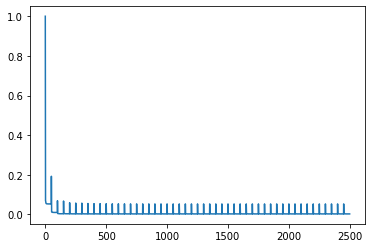

In [24]:
plt.plot(target_sigma[0].squeeze(-1))

In [40]:
kron_kernel.squeeze(1)[0].diagonal()

tensor([1.0004e+00, 3.4877e-02, 3.4874e-02,  ..., 5.4336e-04, 5.4278e-04,
        5.4225e-04])

In [46]:
for elt in kron_kernel.squeeze(1)[0].diagonal():
    print(elt)

tensor(1.0004)
tensor(0.0349)
tensor(0.0349)
tensor(0.0328)
tensor(0.0303)
tensor(0.0285)
tensor(0.0272)
tensor(0.0263)
tensor(0.0256)
tensor(0.0252)
tensor(0.0249)
tensor(0.0248)
tensor(0.0247)
tensor(0.0247)
tensor(0.0247)
tensor(0.0247)
tensor(0.0247)
tensor(0.0246)
tensor(0.0245)
tensor(0.0244)
tensor(0.0243)
tensor(0.0242)
tensor(0.0241)
tensor(0.0240)
tensor(0.0239)
tensor(0.0238)
tensor(0.0237)
tensor(0.0237)
tensor(0.0236)
tensor(0.0236)
tensor(0.0236)
tensor(0.0235)
tensor(0.0235)
tensor(0.0235)
tensor(0.0235)
tensor(0.0235)
tensor(0.0235)
tensor(0.0235)
tensor(0.0235)
tensor(0.0235)
tensor(0.0235)
tensor(0.0235)
tensor(0.0235)
tensor(0.0234)
tensor(0.0234)
tensor(0.0234)
tensor(0.0234)
tensor(0.0233)
tensor(0.0233)
tensor(0.0233)
tensor(0.0349)
tensor(0.0012)
tensor(0.0012)
tensor(0.0011)
tensor(0.0011)
tensor(0.0010)
tensor(0.0009)
tensor(0.0009)
tensor(0.0009)
tensor(0.0009)
tensor(0.0009)
tensor(0.0009)
tensor(0.0009)
tensor(0.0009)
tensor(0.0009)
tensor(0.0009)
tensor(0.0

tensor(0.0007)
tensor(0.0007)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0247)
tensor(0.0009)
tensor(0.0009)
tensor(0.0008)
tensor(0.0007)
tensor(0.0007)
tensor(0.0007)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0

tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0237)
tensor(0.0008)
tensor(0.0008)
tensor(0.0008)
tensor(0.0007)
tensor(0.0007)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0

tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0005)
tensor(0.0005)
tensor(0.0005)
tensor(0.0005)
tensor(0.0005)
tensor(0.0235)
tensor(0.0008)
tensor(0.0008)
tensor(0.0008)
tensor(0.0007)
tensor(0.0007)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0006)
tensor(0.0

In [55]:
kron_kernel[0][0][50]

tensor([0.9998, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000])